In [1]:
'''This script demonstrates how to build a variational
   autoencoder with Keras having multiple heads with losses.

 #Reference

 - Auto-Encoding Variational Bayes
   https://arxiv.org/abs/1312.6114
'''
import os,sys
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm

# Using tensorflow's keras API
import tensorflow
import tensorflow.keras as keras
#import keras
from keras.layers import Input, Dense, Lambda, Layer, Concatenate
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import plot_model

# Set random seeds
def set_seed():
    import numpy, tensorflow, random 
    seed_number = 0 # determinism only works for seed == 0: https://github.com/tensorflow/tensorflow/blob/master/RELEASE.md#bug-fixes-and-other-changes-14
    random.seed(seed_number)
    numpy.random.seed(seed_number)
    tensorflow.set_random_seed(seed_number)

print(tensorflow.VERSION)
print(keras.__version__)

1.12.0
2.1.6-tf


Using TensorFlow backend.


In [2]:
# Setup
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 10
epsilon_std = 1.0
beta = 1.

# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Function for plotting the latent representation
def plot_latent_space(x, z_mean):
    # build a model to project inputs on the latent space
    encoder = Model(x, z_mean)
    # display a 2D plot of the digit classes in the latent space
    x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(6, 6))
    plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='tab10')
    plt.colorbar()
    plt.axis("equal")
    plt.show()

In [3]:
# Single custom loss layer
def VAE_single_custom_layer():
    set_seed()
    x = Input(shape=(original_dim,))
    h = Dense(intermediate_dim, activation='relu')(x)
    z_mean = Dense(latent_dim)(h)
    z_log_var = Dense(latent_dim)(h)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                                  stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    # we instantiate these layers separately so as to reuse them later
    decoder_h = Dense(intermediate_dim, activation='relu')
    decoder_mean = Dense(original_dim, activation='sigmoid')
    h_decoded = decoder_h(z)
    x_decoded_mean = decoder_mean(h_decoded)


    # Custom loss layer
    class CustomLossLayer(Layer):
        def __init__(self, **kwargs):
            self.is_placeholder = True
            super(CustomLossLayer, self).__init__(**kwargs)

        def call(self, inputs):
            x = inputs[0]
            x_decoded_mean = inputs[1]
            z_mean = inputs[2]
            z_log_var = inputs[3]
            xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
            kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
            loss = K.mean(xent_loss + beta * kl_loss)
            self.add_loss(loss, inputs=inputs)
            return inputs # We won't actually use the output.

    y = CustomLossLayer()([x, x_decoded_mean, z_mean, z_log_var])
    vae = Model(x, y)
    vae.compile(optimizer='rmsprop', loss=None)
    plt.figure(figsize=(20,10))
    plot_model(vae, to_file='model.png')
    plt.imshow(matplotlib.image.imread('model.png'))
    plt.show()
    vae.fit(x_train,
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_test, None),
            verbose = 1)
    
    plot_latent_space(x, z_mean)

In [4]:
# Split custom loss layer
def VAE_split_custom_layer():
    set_seed()
    x = Input(shape=(original_dim,))
    h = Dense(intermediate_dim, activation='relu')(x)
    z_mean = Dense(latent_dim)(h)
    z_log_var = Dense(latent_dim)(h)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                                  stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    # we instantiate these layers separately so as to reuse them later
    decoder_h = Dense(intermediate_dim, activation='relu')
    decoder_mean = Dense(original_dim, activation='sigmoid')
    h_decoded = decoder_h(z)
    x_decoded_mean = decoder_mean(h_decoded)


    # Custom loss layer for reconstruction
    class CustomLossLayerReconstruction(Layer):
        def __init__(self, **kwargs):
            self.is_placeholder = True
            super(CustomLossLayerReconstruction, self).__init__(**kwargs)

        def call(self, inputs):
            x = inputs[0]
            x_decoded_mean = inputs[1]
            xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
            self.add_loss(xent_loss, inputs=inputs)
            return inputs # We won't actually use the output.
        
    # Custom loss layer for kl-loss
    class CustomLossLayerKL(Layer):
        def __init__(self, **kwargs):
            self.is_placeholder = True
            super(CustomLossLayerKL, self).__init__(**kwargs)

        def call(self, inputs):
            z_mean = inputs[0]
            z_log_var = inputs[1]
            kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
            self.add_loss(kl_loss, inputs=inputs)
            return inputs # We won't actually use the output.

    y_ent = CustomLossLayerReconstruction()([x, x_decoded_mean])
    y_kl  = CustomLossLayerKL()([z_mean, z_log_var])
    vae = Model(inputs = x, outputs = y_kl + y_ent)
    vae.compile(optimizer='rmsprop', loss=None)
    plot_model(vae, to_file='model.png')
    plt.figure(figsize=(20,10))
    plt.imshow(matplotlib.image.imread('model.png'))
    plt.show()
    vae.fit(x_train,
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_test, None),
            verbose = 1)
    plot_latent_space(x, z_mean)

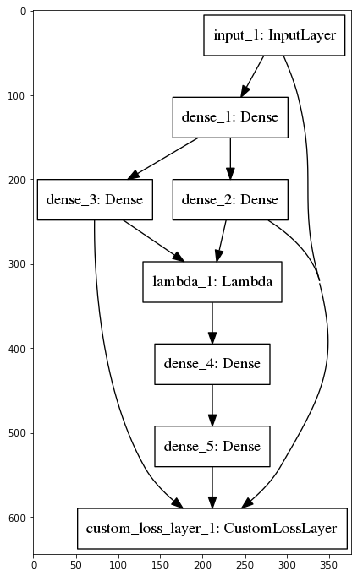

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 64us/step - loss: 190.5037 - val_loss: 171.8317
Epoch 2/10
60000/60000 [==============================] - 3s 51us/step - loss: 170.0072 - val_loss: 167.8208
Epoch 3/10
60000/60000 [==============================] - 3s 51us/step - loss: 166.4808 - val_loss: 165.4143
Epoch 4/10
60000/60000 [==============================] - 3s 52us/step - loss: 164.0167 - val_loss: 163.6236
Epoch 5/10
60000/60000 [==============================] - 3s 51us/step - loss: 162.1661 - val_loss: 161.7431
Epoch 6/10
60000/60000 [==============================] - 3s 50us/step - loss: 160.7253 - val_loss: 160.3197
Epoch 7/10
60000/60000 [==============================] - 3s 50us/step - loss: 159.4892 - val_loss: 159.3314
Epoch 8/10
60000/60000 [==============================] - 3s 52us/step - loss: 158.4660 - val_loss: 158.4809
Epoch 9/10
60000/60000 [==============================] - 3s 51us/step - loss:

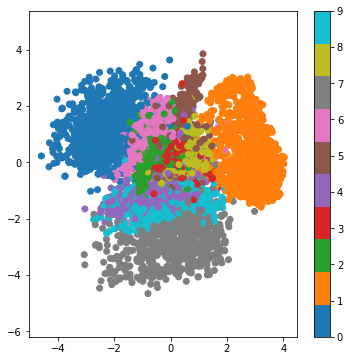

In [5]:
VAE_single_custom_layer()

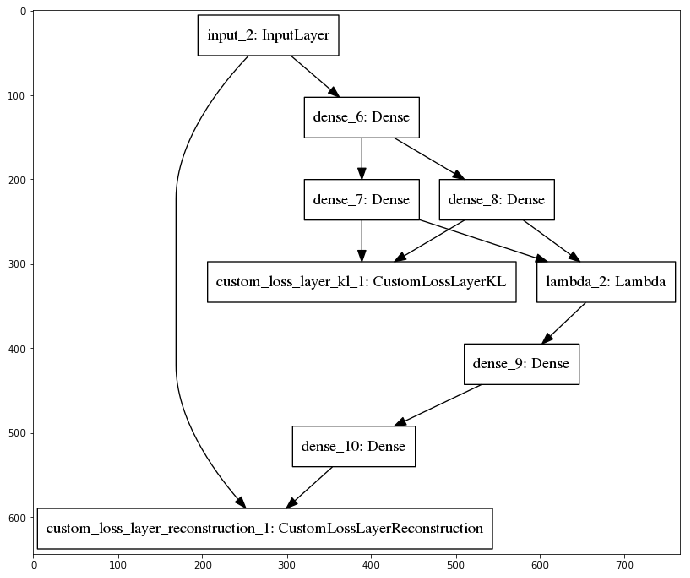

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 56us/step - loss: 190.4891 - val_loss: 171.8836
Epoch 2/10
60000/60000 [==============================] - 3s 50us/step - loss: 170.0731 - val_loss: 167.8931
Epoch 3/10
60000/60000 [==============================] - 3s 50us/step - loss: 166.5164 - val_loss: 165.4584
Epoch 4/10
60000/60000 [==============================] - 3s 49us/step - loss: 163.9926 - val_loss: 163.2189
Epoch 5/10
60000/60000 [==============================] - 3s 49us/step - loss: 162.1344 - val_loss: 161.5720
Epoch 6/10
60000/60000 [==============================] - 3s 49us/step - loss: 160.6959 - val_loss: 160.2785
Epoch 7/10
60000/60000 [==============================] - 3s 51us/step - loss: 159.4748 - val_loss: 159.3789
Epoch 8/10
60000/60000 [==============================] - 3s 52us/step - loss: 158.4824 - val_loss: 158.5610
Epoch 9/10
60000/60000 [==============================] - 3s 52us/step - loss:

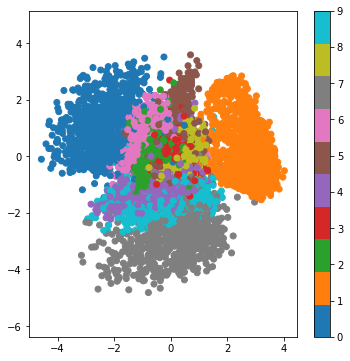

In [6]:
VAE_split_custom_layer()